## This code utilizes Mixed Monotone Reachability to Verify the Safety of RTD-prescribed paths

# Information:

This code is a MM-based adaptation of "step_4_ex_2_trajectory_optimization.m" in the RTD Tutorial Step4: Online Planning

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax
import immrax as irx
from scipy.interpolate import interp1d
import numpy as np
from scipy.io import loadmat
from functools import partial

## Load Data

In [35]:
# Control Data
data = loadmat('export_for_verification/data1.mat')
T_brk = data['T_brk'][0]
U_brk = data['U_brk']
Z_brk = data['Z_brk']


# Obstacle Data
obstacle = loadmat('export_for_verification/obs1.mat')
O = obstacle['O']
O_buf = obstacle['O_buf']
O_pts = obstacle['O_pts']

U_brk = U_brk.T
Z_brk = Z_brk.T # fix row lengths to match T_brk


# Interpolate Path from RTD Toolbox to Verify Safety Along It

In [ ]:
import math

interp_p = jax.core.Primitive("interp")

def interp (t, T, Z) :
    return interp_p.bind(t, T, Z)

def interp_impl (t, T, Z) :
    return jnp.array([jnp.interp(t, T, Z[:,i], left=Z[0,i], right=Z[-1,i]) for i in range(Z.shape[1])])

interp_lowering = jax.interpreters.mlir.lower_fun(interp_impl, False)

def interp_batch(vector_arg_values, batch_axes) :
    res = jax.vmap(interp_impl, batch_axes)(*vector_arg_values)
    return res, 0

def interp_abstract_eval (t, T, Z) :
    return jax.core.ShapedArray((Z.shape[1],), Z.dtype)

def interp_inclusion (t, T, Z) : 
    t = t.lower if isinstance(t, irx.Interval) else t
    T = T.lower if isinstance(T, irx.Interval) else T
    Z = Z.lower if isinstance(Z, irx.Interval) else Z
    res = interp_impl(t, T, Z)
    return irx.interval(res)

interp_p.def_impl(interp_impl)
interp_p.def_abstract_eval(interp_abstract_eval)
jax.interpreters.batching.primitive_batchers[interp_p] = interp_batch
jax.interpreters.mlir.register_lowering(interp_p, interp_lowering)
irx.nif.inclusion_registry[interp_p] = interp_inclusion


# print(sinc((0.01 - T_brk)/0.01))
print(interp(0.001, T_brk, Z_brk))
print(irx.natif(interp)(irx.interval(0.001), T_brk, Z_brk))

[8.4991864e-04 4.2407246e-06 9.9790492e-04 8.4993267e-01]
[[(8.49918637e-04, 8.49918637e-04)]
 [(4.24072459e-06, 4.24072459e-06)]
 [(9.97904921e-04, 9.97904921e-04)]
 [(8.49932671e-01, 8.49932671e-01)]]


## Define Helper Functions

In [38]:
def saturate_input(u):
    turtlebot_max_yaw_rate = 2.0 # rad/s
    turtlebot_max_accel = 2.0 # m/s^2

    min_rate = -turtlebot_max_yaw_rate
    max_rate = turtlebot_max_yaw_rate
    min_accel = -turtlebot_max_accel
    max_accel = turtlebot_max_accel


    mins = jnp.array([min_rate, min_accel])
    maxs = jnp.array([max_rate, max_accel])

    return jnp.clip(u, mins, maxs)


def rotation_matrix_2D(theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                      [jnp.sin(theta), jnp.cos(theta)]])

def match_trajectories(t_fdbk, *varargin):
    numout = len(varargin) // 2
    out = []
    for i in range(numout) :
        T, Z = varargin[2*i], varargin[2*i+1]
        out.append(jnp.array([jnp.interp(t_fdbk, T, Z[:,i], left=Z[0,i], right=Z[-1,i]) for i in range(Z.shape[1])]))    
    return out

In [39]:
def get_control_inputs(t_curr, z_curr):
    # define gains
    k_p = 9
    k_v = 12
    k_a = 1
    k_h = 1
    k_w = 1
    k_hp = 0
    
    # define parameters
    t_lkhd = 0.01
    t_fdbk = jnp.minimum(t_curr + t_lkhd, T_brk[-1])

    # get current state
    # print(z_curr.shape)
    p_cur = z_curr[0:2]
    h_cur = z_curr[2]
    v_cur = z_curr[3]

    # get desired state and inputs (assumes zero-order hold), we are doing feedforward about a desired trajectory
    u_des = interp(t_fdbk, T_brk, U_brk)
    z_des = interp(t_fdbk, T_brk, Z_brk)
    p_des = z_des[0:2]
    v_des = z_des[3]
    h_des = z_des[2]

    # get desired feedforward inputs
    w_des = u_des[0]
    a_des = u_des[1]


    R = rotation_matrix_2D(h_cur)
    x = p_des - p_cur


    p_err = R@x
    px_err = p_err[0]
    
    # compute heading relative to desired position
    hp_err = jnp.arctan(p_err[1]/p_err[0])


    # compute unsaturated inputs (they get saturated by the agent)
    w_out = k_h*(h_des - h_cur) + k_w*w_des + k_hp*hp_err
    a_out = k_p*px_err + k_v*(v_des - v_cur) + k_a*a_des

    U = jnp.array([w_out, a_out])
    return U




### Now Test Everything We've Done So Far

In [40]:
t_curr = 0
# t_curr = 0.135999766496351
z_curr = np.array([0, 0, 0, 0.5])#.reshape(4,1)
t_lkhd = 0.01


U = get_control_inputs(t_curr, z_curr)
print(f"U: {U}")
final_u = saturate_input(U.squeeze())
print(f"final_u: {final_u}")
print(f'{t_curr=}, {z_curr=}')



[1.0078838 4.275685 ]
final_u: [1.0078838 2.       ]
t_curr=0, z_curr=array([0. , 0. , 0. , 0.5])


In [41]:
# All of the above code is used to define the function u_map
def u_map(t,z):
    # u = irx.interval(get_control_inputs(t_curr, z_curr, T_brk, U_brk, Z_brk).squeeze())
    u_des = get_control_inputs(t, z)
    u_sat = saturate_input(u_des)
    # u_sat = t*jnp.ones(2)
    # print(f"u_sat: {u_sat}")
    return u_sat

# w_map right now is empty, but ready for future implementation where we'd like to see noise
def w_map(t, z):
    return jnp.array([0., 0., 0., 0.])

In [42]:
u_map(t_curr, z_curr)

iz_curr = irx.icentpert(z_curr, 0.01)
print(f"{iz_curr = }")
iw_map = lambda t, x : irx.icentpert([0., 0., 0., 0.], [0.0, 0.0, 0.0, 0.0])

iz_curr = [-0.01 -0.01 -0.01  0.49] <= x <= [0.01 0.01 0.01 0.51]


In [43]:

class TurtleBot (irx.ControlledSystem) :
    def __init__ (self) :
        self.evolution = 'continuous'
        self.xlen = 4

    def f(self, t, x, u, w):
        # print(f"x: {x}")
        # print(f"u: {u}")
        px, py, h, v = x.squeeze()
        u1, u2 = u.squeeze()
        w1, w2, w3, w4 = w

        xd = v*jnp.cos(h) + w1
        yd = v*jnp.sin(h) + w2
        hd = u1 + w3
        vd = u2 + w4

        zd = jnp.array([xd, yd, hd, vd])
        return zd

class TurtleBotControl (irx.Control) :
    def u (self,t,x) :
        return u_map(t,x)


olsys = TurtleBot()
control = TurtleBotControl()
sys = irx.ControlledSystem(olsys, control)
embsys = irx.natemb(sys)
# embsys = irx.mjacemb(sys)

# def func(t,y,args):
#     return f(t,y,u_map(t,y))

# # func = lambda t, y, input: f(t,y, input)
# print("in f")

# out = func(t_curr, z_curr, None)
# print(f"out: {out}")

In [44]:
from diffrax import diffeqsolve, ODETerm, Dopri5, Tsit5, Euler, SaveAt, AbstractSolver
import jax.numpy as jnp

t0 = 0.0
tf = T_brk[-1]
dt = 0.01
print(f"t0: {t0}")
print(f"tf: {tf}")
print(f"dt: {dt}")

# term = ODETerm(func)
# # print(f"term: {term}")
# solver = Dopri5()
# y0 = jnp.array([0., 0., 0.,.5])
# saveat = SaveAt(t0=True, t1=True, steps=True)
# traj = diffeqsolve(term, solver, t0=t0, t1=tf, dt0=0.01, y0=y0, saveat=saveat)
# traj = sys.compute_trajectory(t0, tf, z_curr, (u_map, w_map), dt, solver='rk45')
# embtraj = embsys.compute_trajectory(t0, tf, irx.i2ut(iz_curr), (iu_map, iw_map), dt, solver='rk45')


t0: 0.0
tf: 0.9249663441924902
dt: 0.01


In [46]:
traj = sys.compute_trajectory(t0, tf, z_curr, (w_map,), dt, solver='rk45')

In [50]:
tfinite = jnp.where(jnp.isfinite(traj.ts))
tt = traj.ts[tfinite]
xx = traj.ys[tfinite]

ixx = embtraj.ys[tfinite]
print(irx.ut2i(ixx[-1]))

print(f"tt.shape: {tt.shape}")
print(f"xx.shape: {xx.shape}")
xf = xx[-1]
print(f"xf: {xf}")
# print(irx.ut2i(xf))
xf = irx.interval(xf)

[[(5.04085124e-01, 0.54873383)]
 [(1.87497497e-01, 0.22643273)]
 [(7.03036249e-01, 0.71096754)]
 [(1.86641366e-04, 0.03772682)]]
tt.shape: (94,)
xx.shape: (94, 4)
xf: [0.5261956  0.20674083 0.7070013  0.01801238]


<Figure size 640x480 with 0 Axes>

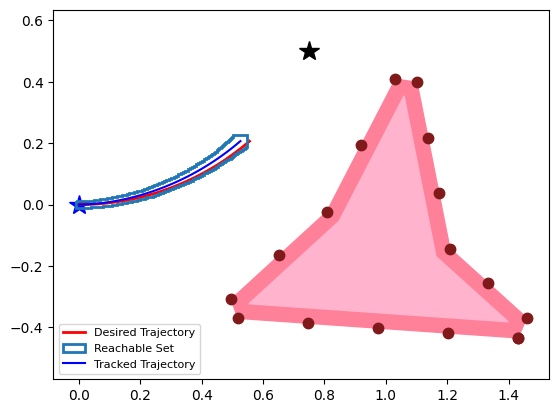

In [55]:
### Plot Everything
import matplotlib.pyplot as plt 
from immrax.utils import get_partitions_ut, run_times, draw_iarrays, gen_ics, draw_iarray

x_des = 0.75 # robot desired location
y_des = 0.5
z0 = z_curr # initial location
zx0 = z_curr[0] 
zy0 = z_curr[1] 
ZXs = Z_brk[:,0] #desired path
ZYs = Z_brk[:,1]


plt.figure(1) # Create a Figure
fig, ax = plt.subplots()

ax.fill(O_buf[0], O_buf[1], color=[1, 0.5, 0.6]) # Plot the buffered obstacle
ax.fill(O[0], O[1], color=[1, 0.7, 0.8]) # Plot actual obstacle
ax.plot(O_pts[0,:], O_pts[1,:], '.', color=[0.5, 0.1, 0.1], markersize=15) # Plot discretized obstacle border
ax.plot(x_des, y_des, 'k*', linewidth=2, markersize=15) # Plot the desired location of the robot
ax.plot(zx0, zy0, 'b*', linewidth=2, markersize=15) # Plot the current location of the robot
ax.plot(ZXs, ZYs, 'r', linewidth=2, markersize=15, label='Desired Trajectory') # Plot the desired path of the robot

# Plot reachable set hyperrectangular over-approximations over time or their union
# for ix in ixx :
#     irx.utils.draw_iarray(ax, irx.ut2i(ix), zorder=1)
irx.utils.draw_iarrays(ax, [irx.ut2i(ix) for ix in ixx], zorder=2, label='Reachable Set') 


ax.plot(xx[:,0], xx[:,1], 'b', markersize=2, label='Tracked Trajectory') #Plot the nominal trajectory with zero disturbance or uncertainty in the input
# ax.set_aspect('equal', 'box')
ax.axis('equal')
ax.legend(loc="lower left", fontsize="8")

plt.show() # Show the plot

